# Séance 3 : Segmentation d'images

Dans cette partie, nous allons nous pencher sur une problématique très fréquente : comment découper automatiquement une images en sous-parties ? La définition d'une « sous-partie » va fortement dépendre du problème considéré. En général, on aimerait qu'une sous-partie corresponde à une notion *sémantique* (par exemple, un chat, un chien, un téléphone, une voiture) mais dans une image, nous n'avons accès qu'aux valeurs des pixels. Heureusement, ces valeurs sont souvent suffisamment informatives pour séparer différents objets, quand bien même l'algorithme n'a aucune idée de ce qu'ils représentent.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io

plt.rcParams['figure.figsize'] = (10, 10)

## Approche par binarisation

Une première façon de s'en sortir consiste à utiliser les techniques de seuillage vues dans la première séance. Si le contraste entre les objets à segmenter et l'arrière-plan est suffisamment grand, une binarisation directe peut suffire à isoler les objets d'intérêt du reste de l'image.

In [ ]:
image = skimage.data.coins()[50:-50, 50:-50]
plt.imshow(image, cmap="gray") and plt.show()

Nous pouvons binariser cette image en utilisant un algorithme de seuillage, comme la technique d'Otsu ou celle de Niblack :

In [ ]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(image)
plt.imshow(image > thresh) and plt.show()

On peut maintenant extraire les composantes connectées de la carte binarisée, c'est-à-dire les composants telles qu'il existe un chemin continu permettant de relier chaque paire de pixels de cette composante :

In [ ]:
from skimage.measure import label

plt.imshow(label(image > thresh)) and plt.show()

Chaque couleur correspond à un « objet » unique identifié par notre algorithme de segmentation. On remarque que même si les pièces sont bien séparées, tout n'est pas parfait :
- il y a des trous dans les pièces,
- que faire des pièces « mangées » par les bords de l'image ?
- il y a des artefacts (des petites zones d'arrière-plan considérées comme des objets).

## Filtres morphologiques et post-traitement

La solution pour tous ces problèmes réside dans un outil bien pratique : le filtrage morphologique. La théorie de la morphologie mathématique a été développée à partir de 1964 par Georges Matheron et Jean Serra à l'école des Mines de Paris.

Globalement, les filtres morphologiques tendent à avoir les propriétés suivantes :
- non-linéarité,
- non-inversibilité,
- idempotence (appliquer deux fois le même filtre donne le même résultat qu'une seule fois).

Les filtres morphologiques s'appliquent sur des images binaires, c'est-à-dire une image $I: (i,j) \rightarrow \{0,1\}$.

Le point central de la morphologie mathématique est la notion d'**élément structurant**. Cet élément va se promener sur l'image à traiter et on considérera des relations entre le pixel à traiter et ses voisins dans l'élément structurant. Un élément structurant peut avoir n'importe quel forme mais on considérera généralement des carrés ou des disques.

Commençons par les deux opérations les plus communes du filtrage morphologique : les dilations et les érosions.

La notation mathématique est un peu lourde mais le principe est simple.

Par la suite, on note $I^+$ (resp. $I^-$) le sous-ensemble des pixels positifs (resp. négatifs) de l'image $I$. On note $B$ l'élément structurant et $B_{x,y}$ l'élément structurant centré sur le pixel de coordonnées $(x,y)$.

### Érosion

L'érosion conserve un pixel $(x,y) \in I^+$ si tous ses voisins contenus dans l'élément structurant centré en $(x,y)$ sont positifs. Sinon, le pixel $(x,y)$ est supprimé. Les pixels de $I^-$ sont inchangés.

$$\epsilon_B (I^+) = I^+ \ominus B = \{(x,y) | B_{x,y} \subset I^+\}$$

### Dilation

La dilation ajoute un pixel $(x,y) \in I^-$ aux positifs si au moins un de ses voisins dans l'élément structurant est positif. Les pixels de $I^+$ sont inchangés.

$$\delta_B (I^+) = I^+ \oplus B = \{ u + b | b \in B, u \in I^+\} = \bigcup_{(x,y) \in I^+} B_{x,y}$$

### Exemple

Image d'origine :

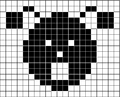

Dilation par un carré $3\times 3$ :

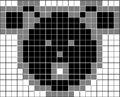

Érosion par un carré $3 \times 3$ :
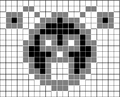

Les pixels gris correspondent aux pixels ajoutés ou retirés.

### Ouverture et fermeture

À partir de l'érosion et de la dilation qui sont les opérations de base de la morphologie mathématique, nous pouvons définir des opérations plus sophistiquées.

L'**ouverture** morphologique d'une image est le résultat d'une érosion suivie d'une dilatation par le même élément structurant. L'ouverture retire les objets plus petits que l'élément structurant et peut créer une « ouverture » dans un objet plus grand :

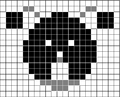

À l'inverse, la **fermeture** morphologique d'une image est composée d'une dilatation suivie d'une érosion. La fermeture retire les « trous » d'un objet plus petits que l'élément structurant et peut permettre de compléter un objet pas complètement segmenté.

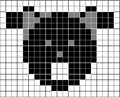

Mettons ces filtres en application sur notre image segmentée. Les outils de morphologie mathématique sont implémentés dans `scikit-image` dans le sous-module `morphology`.

Nous avons des trous dans les pièces que nous souhaitons combler. Commençons par définir l'élément structurant : 

In [ ]:
from skimage.morphology import square

# Carré 3x3
selem = square(3)

Puis appliquons une fermeture morphologique :

In [ ]:
from skimage import morphology

bw = morphology.closing(image > thresh, square(3))
plt.imshow(bw) and plt.show()

La segmentation est nettement meilleure : les composantes connexes correspondant au pièce sont maintenant presque parfaitement circulaires, sans trous.

Pour retirer les petits artefacts, on peut soit utiliser une ouverture morphologique :

In [ ]:
plt.imshow(morphology.opening(bw)) and plt.show()

Soit utiliser la méthode `remove_small_objects`, qui permet de retirer toutes composantes connexes dont la surface est inférieure à `min_size` pixels :

In [ ]:
bw = morphology.remove_small_objects(bw, min_size=30) # 30 pixels min
plt.imshow(bw) and plt.show()

Tant qu'à faire, faisons la même chose pour les trous dont la surface est inférieure à `min_size` pixels :

In [ ]:
bw = morphology.remove_small_holes(bw, area_threshold=30) # 30 pixels min
plt.imshow(bw) and plt.show()

La fonction `label` permet d'assigner un identifiant entier unique à chaque composante connectée de l'image :

In [ ]:
label_image = label(bw)
plt.imshow(label_image) and plt.show()

In [ ]:
from skimage import color

image_label_overlay = color.label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Approche par contours

La segmentation par contours est très similaire à l'approche par binarisation mais exploite (comme son nom l'indique) les contours de l'image plutôt que les intensités.
Commençons donc par appliquer un filtre de Canny sur l'image :

In [ ]:
from skimage import feature
edges = feature.canny(image)
plt.imshow(edges, cmap="gray") and plt.show()

Une façon de retrouver les segments est, par exemple, de réaliser une fermeture morphologique :

In [ ]:
plt.imshow(morphology.closing(edges, square(5))) and plt.show()

On peut alors utiliser les fonctions `remove_small_objects` et `remove_small_holes` pour terminer le post-traitement.

Bien que les approches par binarisation ou basées sur les contours fonctionnent, elles ont quelques inconvénients. Le principal est qu'elles tendent à sous-segmenter l'image, c'est-à-dire à produire moins de subdivision que ce que l'on aimerait. Nous allons voir une approche qui prend le parti inverse de proposer une *sursegmentation*.

## Segmentation et clustering

Le *clustering* (ou partitionnement de données) consiste à diviser un ensemble de données en paquets similaires. Par similaires, on entend « qui partagent des caractéristiques communes », ce que l'on définit souvent par une notion de distance.

Formellement, on peut considérer un ensemble $\mathcal{D} = \{x_1, x_2, \ldots, x_n\}$ de valeurs. L'objectif est de construire $k$ sous-ensembles $C_1, C_2, \ldots, C_n$ mutuellement exclusifs de $\mathcal{D}$ tels que si $x_i$ et $x_j$ appartiennent au même groupe $C_p$, alors ces valeurs sont « proches » :
- $\forall p \in [1 ; k],~~~~~ C_p \subset \mathcal{D}$
- $\forall (p,q) \in [1 ; k]^2,~~~~~ p \neq q \implies C_p \cap C_q = \varnothing $
- $\forall (x_i, x_j) \in \mathcal{D}^2,~~~~~~~ x_i \in C_p~~\text{et}~~x_j \in C_p \implies d(x_i, x_j) \leq \tau$

Dans notre cas, les $x_i$ seront des pixels ($x_i \in \mathbb{R}$ pour une image en niveaux de gris ou $x_i \in \mathbb{R}^3$ pour une image couleur).

### Couleurs principales

Une application simple du clustering consiste à trouver les couleurs « centrales » d'une image, c'est-à-dire les couleurs qui sont en moyenne les plus proches des autres et qui résument bien l'image.

Pour ce faire, on peut utiliser l'algorithme des K-moyennes (k-*means*). L'objectif de l'algorithme est de mettre les pixels dans des groupes $C_1, \dots, C_k$ de sorte à minimiser la distance entre les couleurs contenues dans chaque groupe.

Mathématiquement, on cherche :

$$C_1, \dots, C_k = \arg\min \sum_{i=1}^k \sum_{x_j \in C_i} \| x_j - m_i \|^2$$

avec $m_i$ le barycentre des couleurs des pixels de $C_i$.

Pour ce faire, l'algorithme des k-moyennes agit de la façon suivante :
1. tirer $k$ couleurs au hasard  qui représentent $m_1^{(0)}, \ldots, m_k^{(0)}$ les centres initiaux.
2. Jusqu'à ce que $r$ ne diminue plus:
    1. ajouter chaque observation au groupe de la couleur la plus proche : $\text{groupe}(x_i) = \arg\min_j \| x_i - m_j \|^2$
    2. mettre à jour les moyennes : $m_i^{(t+1)} = \frac{1}{|C_i^{(t)}|} \sum_{x_j \in C_i} x_j$

Cet algorithme est implémenté dans la bibliothèque `scikit-learn` (une cousine de `scikit-image`). Appliquons sur une image de test et regardons les couleurs moyennes que l'on obtient. Comme d'habitude, prenons notre image de chat.

In [ ]:
cat = skimage.data.cat()
plt.imshow(cat) and plt.show()

In [ ]:
import sklearn.cluster

n_colors = 3 # modifiez pour choisir le nombre de couleurs que vous voulez conserver
kmeans = sklearn.cluster.KMeans(n_clusters=n_colors, n_init=1)
X = cat.reshape(-1, 3) # liste de pixels

Sans rentrer les détails La méthode `.fit()` permet d'appliquer l'algorithme des k-moyennes ci-dessus aux données contenues dans la variable `X` :

In [ ]:
kmeans.fit(X)

Les centres des groupes (c'est-à-dire les couleurs) sont stockées dans l'attribut `kmeans.cluster_centers_`. Le code ci-dessous permet d'afficher visuellement les couleurs obtenues :

In [ ]:
fig, ax = plt.subplots(figsize=(8, 1))
for idx, color in enumerate(kmeans.cluster_centers_):
    ax.add_patch(plt.Rectangle((idx*10, 0), 10, 10, facecolor=color/256))
plt.axis("off")
plt.xlim(0, 10*n_colors)
plt.ylim(10)
plt.show()

N'hésitez pas à tester avec plus de couleurs ou avec vos propres images !

## SLIC : simple linear iterative clustering

Les algorithmes de segmentation de `scikit-image` sont habilement cachés dans le sous-module… `segmentation`. Commençons par l'importer avant d'examiner ce qui s'y trouve.

In [ ]:
from skimage import segmentation

In [ ]:
sorted(segmentation.__all__)

L'algorithme qui nous intéresse est l'algorithme SLIC ¹ : simple linear iterative clustering. L'idée de SLIC est d'appliquer l'algorithme des k-moyennes dans l'espace couleur-(x,y), c'est-à-dire sur les valeurs des pixels **et** leurs coordonnées. Cela permet de définir qu'une région (un groupe pour k-*means*) correspond à une zone de pixels proches et de couleur similaire.

¹ : développé par [Radhakrishna Achanta, Appu Shaji, Kevin Smith, Aurélien Lucchi, Pascal Fua et Sabine Süsstrunk en 2010](https://www.epfl.ch/labs/ivrl/research/slic-superpixels/).

**Question** : SLIC passe en espace L\*a\*b\* pour réaliser le *clustering* avec l'algorithme des k-moyennes. Pourquoi à votre avis ?

Réalisons un test sur une image simple :

In [ ]:
# on laisse tomber la transparence de l'image
marge = skimage.color.rgba2rgb(io.imread("images/Marge.png"))
plt.imshow(marge) and plt.show()

Le fonction `slic` possède plusieurs paramètres. Les principaux sont :
- `n_segments` : le nombre (approximatif) de régions désiré (par défaut, 100),
- `compactness` : à quel point on privilégie la distance dans le plan ou la distance colorimétrique. Plus la compacité est élevée, plus on privilégie la distance dans le plan (et les régions sont régulières). (par défaut, 10.0).

Elle renvoie une image de mêmes dimensions mais contenant pour chaque pixel le numéro de la région associée.

In [ ]:
regions = segmentation.slic(marge, start_label=1)
plt.imshow(regions) and plt.show()

La fonction `segmentation.mark_boundaries` permet de superposer l'image avec les frontières des régions obtenues :

In [ ]:
plt.imshow(segmentation.mark_boundaries(marge, regions, color=(0,0,0))) and plt.show()

La segmentation fonctionne bien dans ce cas mais l'image est assez simple et contient peu de couleurs, avec des transitions fortes. Voyons comment SLIC se comporte sur une image un peu plus difficile.

In [ ]:
cat = skimage.data.cat()
regions = segmentation.slic(cat, start_label=1)
plt.imshow(segmentation.mark_boundaries(cat, regions, color=(0,0,0))) and plt.show()

Contrairement à précédemment avec les méthodes par contours ou par binarisation, SLIC produit nettement plus de régions que nécessaire. En revanche, les régions de SLIC ont une taille à peu près similaire. Dans le cas de SLIC, on parlera plutôt d'un algorithme de *superpixels* plutôt que de segmentation.

Le paradigme *superpixels* s'intéresse plutôt à créer une version alternative de l'image où les pixels similaire sont regroupés dans un seul *superpixel*. Le superpixel n'est pas forcément autonome, pour réaliser une segmentation, il faudra ensuite le fusionner avec ses voisins.

## Segmentation par remplissage

Une autre technique bien utile de segmentation est d'utiliser l'[algorithme de remplissage par diffusion](https://fr.wikipedia.org/wiki/Algorithme_de_remplissage_par_diffusion). Le concept est assez simple :
1. on donne en entrée la position du pixel de départ et la couleur choisie,
2. on ajoute le pixel de départ dans une pile,
3. on dépile le pixel en haut dans la pile, on note $c$ sa couleur :
    - on le colorie dans la couleur choisie,
    - pour chaque pixel voisin qui est de la couleur $c$, on l'ajoute dans la pile,
    - répéter tant que la pile n'est pas vide.

C'est l'approche utilisée pour le remplissage en mode "seau" dans les logiciels de dessin et d'édition d'image comme Paint ou Photoshop.

Cet algorithme est implémenté dans `scikit-image` dans la fonction `segmentation.flood_fill`.

In [ ]:
checkers = skimage.data.checkerboard()

# on remplit en gris (127) à partir du pixel en position (76, 76)
seed = (76, 76)
filled_checkers = segmentation.flood_fill(checkers, seed, 127)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(121)
plt.imshow(checkers, cmap=plt.cm.gray) and plt.title('Image de départ')
fig.add_subplot(122)
plt.imshow(filled_checkers, cmap=plt.cm.gray)
plt.plot(*seed, marker='o', c="white") # affiche le point de départ
plt.title('Après remplissage')

plt.show()

Par défaut, on considère que le remplissage se fait pour tous les voisins qui sont strictement de même couleur. Cela ne fonctionne pas très bien pour des images complexes (notamment pour des photos). On peut alors régler le paramètre `tolerance` qui permet de dire : « remplir les voisins s'ils sont de la même couleur ou au plus différent du facteur de tolérance ».

**Question** : essayez d'ajouter `tolerance=50` dans le remplissage ci-dessus. Que se passe-t-il ? Pourquoi ?

Il existe aussi une fonction `flood` qui applique le même algorithme mais renvoie le masque correspondant à la région segmentée, sans la colorier:

In [ ]:
mask = segmentation.flood(checkers, seed, tolerance=0)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(121)
plt.imshow(checkers, cmap=plt.cm.gray)
plt.title('Image de départ')

fig.add_subplot(122)
plt.imshow(mask, cmap=plt.cm.gray)
plt.title('Masque')

plt.show()

Une astuce pratique est d'utiliser les fonctions de remplissage non pas sur l'image de base, mais sur les gradients (voire sur les cartes de contours). Un exemple amusant tiré de la documentation de `scikit-image`:

In [ ]:
from skimage import filters
from skimage import color

cat = skimage.data.chelsea()
# Filtrage de Sobel pour extraire les pseudo-contours
cat_sobel = filters.sobel(color.rgb2gray(cat))
# On sélectionne seulement les zones à faible gradient autour de la truffe du chat
cat_nose = segmentation.flood(cat_sobel, (240, 265), tolerance=0.02)

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 20))

ax[0].imshow(cat)
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(cat_sobel)
ax[1].set_title('Filtrage de Sobel')
ax[1].axis('off')

ax[2].imshow(cat)
ax[2].imshow(cat_nose, cmap=plt.cm.gray, alpha=0.3)
ax[2].plot(265, 240, 'wo')  # seed point
ax[2].set_title('Truffe segmentée')
ax[2].axis('off')

fig.tight_layout()
plt.show()

On peut ensuite changer légèrement la couleur de la truffe, par exemple en repassant dans l'espace HSV :

In [ ]:
cat_hsv = color.rgb2hsv(cat)
cat_hsv[cat_nose, 0] = 0.8 # on modifie seulement la teinte (hue)
plt.imshow(color.hsv2rgb(cat_hsv)) and plt.show()

## Watershed

Un autre algorithme de segmentation populaire est l'algorithme *watershed* (en français, ligne de partage des eaux). Le principe est assez intuitif : on considère une image en niveaux de gris comme un relief topographique (intensité lumineuse = hauteur). On place ensuite des marqueurs à différents endroits de l'image. Ces marqueurs vont agir comme des sources.

On fait monter progressivement le niveau de l'eau à partir des sources, inondant tous les pixels dont la hauteur est inférieure à celle des sources. Les frontières entre les régions correspondent aux pixels où deux bassins provenant de deux sources différentes se rencontrent.

L'avantage de *watershed* est que, si l'on a bien choisi les marqueurs de départ, on peut segmenter des objets qui se recouvrent partiellement. Prenons un exemple sur une image binaire :

In [ ]:
from skimage import segmentation
from skimage.draw import disk

image = np.zeros((80, 80), dtype="int")
rr, cc = disk((28, 28), radius=16)
image[rr, cc] = 1
rr, cc = disk((44, 52), radius=20)
image[rr, cc] = 1
plt.imshow(image, cmap="gray") and plt.show()

Une première façon de définir les marqueurs consiste à calculer ce que l'on appelle la carte des distances. Pour chaque pixel positif $(x,y)$, on calcule la distance euclidienne de ce pixel au point négatif le plus proche :

$$d(x,y) = \min_{(x',y') \in I^-} \sqrt{(x-x')^2 + (y-y')^2}$$

en notant $I^+$ l'ensemble des pixels positifs et $I^-$ l'ensemble des pixels négatifs de l'image.

Cette carte de distance s'obtient aisément à l'aide de SciPy :

In [ ]:
from scipy import ndimage as ndi
distance = ndi.distance_transform_edt(image)
plt.imshow(distance) and plt.show()

On place alors les marqueurs initiaux pour *watershed* aux emplacements des maxima locaux de la carte de distances :

In [ ]:
from skimage.feature import peak_local_max
coords = peak_local_max(distance, footprint=np.ones((5,5)), labels=image)

plt.imshow(image)
plt.scatter(coords[:,1], coords[:,0], marker="+", s=200)
plt.show()

Les marqueurs doivent être représentés sous la forme d'une matrice de même dimensions que l'image. Chaque marqueur est identifié par un entier unique. À défaut, `scikit-image` utilisera les minima locaux de l'image, ce qui n'est pas ce que l'on souhaite pour le moment.

In [ ]:
markers = np.zeros_like(distance).astype("int")
for idx, (x, y) in enumerate(coords):
    markers[x,y] = idx + 1

On applique ensuite *watershed* sur l'opposé de la carte de distance (plus on est loin du bord, plus on considère la profondeur élevée, c'est-à-dire la hauteur faible). On n'étiquette que les parties positives de l'image grâce à l'option `mask=image`.

In [ ]:
regions = segmentation.watershed(-distance, markers, mask=image)
plt.imshow(regions) and plt.show()

La difficulté dans *watershed* consiste à bien choisir les marqueurs, c'est-à-dire les sources de départ. Pour une image binaire, l'utilisation de la carte de distance est plutôt appropriée. Mais pour une image classique en niveaux de gris, que choisir ?

Reprenons l'exemple des pièces :

In [ ]:
coins = skimage.data.coins()
plt.imshow(coins, cmap="gray") and plt.show()

On ne va pas appliquer *watershed* sur l'image directement mais plutôt sur la carte d'intensité de ses gradients :

In [ ]:
from skimage import filters
elevation_map = filters.sobel(coins)
plt.imshow(elevation_map, cmap="gray") and plt.show()

Si l'on veut détecter les pièces, une possibilité pour le choix des marqueurs consiste à utiliser l'histogramme des intensités et à placer des marqueurs dans tous les pixels correspondant aux 5% des pixels les plus sombres et aux 5% des gradients les plus clairs dans l'image de départ :

In [ ]:
markers = np.zeros_like(coins)
markers[coins < np.percentile(coins, 5)] = 1
markers[coins > np.percentile(coins, 95)] = 2
plt.imshow(markers) and plt.show()

Puis on applique *watershed* en utilisant la carte des gradients comme carte de hauteur. Les gradients élevés vont faire office de « barrière » pour l'eau lors de la phase d'inondation :

In [ ]:
regions = segmentation.watershed(elevation_map, markers)
plt.imshow(regions) and plt.show()

# Stylisation d'une image par segmentation en régions

Pour terminer cette partie, un petit exercice. Nous allons styliser une image pour lui donner un effet « mosaïque » en utilisant les algorithmes que nous avons vu jusqu'à présent.

L'approche est la suivante :
1. découper l'image en régions (en utilisant un algorithme de votre choix de `skimage.segmentation`)
2. pour chaque région :
    - calculer la valeur moyenne (ou médiane) du pixel (dans l'espace RGB ou dans l'espace L\*a\*b)
    - remplacer tous les pixels par la valeur moyenne
3. afficher l'image obtenue

Expérimentez avec différents algorithmes de segmentation et différents réglages pour trouver l'effet qui vous plaît le plus !


### À vous de jouer !

In [ ]:
cat = skimage.data.cat()
regions = segmentation.slic(cat, start_label=1)
plt.imshow(segmentation.mark_boundaries(cat, regions, color=(0,0,0))) and plt.show()

**Note** : cet exercice permet certes de styliser l'image mais il permet aussi d'améliorer la segmentation obtenue par SLIC. En utilisant la couleur moyenne ou médiane d'un superpixel, on peut ainsi la comparer à celle des superpixels voisins. Si ces couleurs sont proches (distance inférieure à un seuil), alors on peut décider de fusionner les superpixels. Cela permet d'obtenir une segmentation qui colle mieux aux régions réelles de l'image et qui est moins sur-segmentée. Une version expérimentale de cet algorithme de fusion (en utilisant les graphes) est disponible dans `scikit-image`, voir [cet exemple dans la documentation](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_rag_merge.html).